Install needed packages

currently use a bruteforce method

ln -s /usr/local/cuda/lib64/libnvrtc-builtins.so.10.0.130 /usr/local/EMAN2/lib/libnvrtc-builtins.so

In [1]:
!pip install pillow
!pip install numpy
# if system has CUDA 10.1, install cupy-cuda101
!pip install cupy-cuda100

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest

Load an image

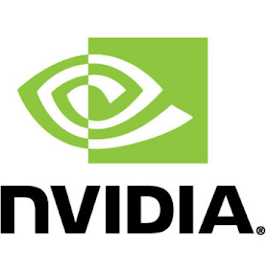

In [1]:
import sys
sys.path.insert(0, "/usr/local/cuda/lib64")
from PIL import Image
logo_img = Image.open('logo.png')

from IPython.display import display
display(logo_img)

Convert image to RGB map, RGBRGBRGB... -> RRR...RGGG...GBBB...B

Convert RGB map to numpy array, then convert numpy array to cupy array

In [2]:
(r, g, b) = logo_img.split()
import numpy as np
r_array = np.array(r)
g_array = np.array(g)
b_array = np.array(b)
logo_array = np.stack((r_array, g_array, b_array))

In [3]:
import cupy as cp
in_gpu_array = cp.array(logo_array)
out_gpu_array = cp.empty_like(in_gpu_array)

In [4]:
cp.__version__

'6.7.0'

In [5]:
import os
os.environ['LD_LIBRARY_PATH']='/usr/local/cuda/lib64:'+os.environ['LD_LIBRARY_PATH']

In [6]:
os.environ['CUDA_PATH']='/usr/local/cuda'

In [7]:
%env

{'BAZELRC': '/home/phonchi30/.bazelrc',
 'CLICOLOR': '1',
 'CONDA_DEFAULT_ENV': 'base',
 'CONDA_EXE': '/usr/local/EMAN2/bin/conda',
 'CONDA_PREFIX': '/usr/local/EMAN2',
 'CONDA_PROMPT_MODIFIER': '(base) ',
 'CONDA_PYTHON_EXE': '/usr/local/EMAN2/bin/python',
 'CONDA_SHLVL': '1',
 'CREATOR_ACCOUNT': 'phonchi30',
 'CUDA_PATH': '/usr/local/cuda',
 'CUDA_PKG_VERSION': '10-0=10.0.130-1',
 'CUDA_VERSION': '10.0.130',
 'CUDNN_VERSION': '7.6.5.32',
 'GIT_PAGER': 'cat',
 'HAZC3FCTR1601451635425_PORT': 'tcp://10.104.249.46:50635',
 'HAZC3FCTR1601451635425_PORT_50635_TCP': 'tcp://10.104.249.46:50635',
 'HAZC3FCTR1601451635425_PORT_50635_TCP_ADDR': '10.104.249.46',
 'HAZC3FCTR1601451635425_PORT_50635_TCP_PORT': '50635',
 'HAZC3FCTR1601451635425_PORT_50635_TCP_PROTO': 'tcp',
 'HAZC3FCTR1601451635425_PORT_51747_TCP': 'tcp://10.104.249.46:51747',
 'HAZC3FCTR1601451635425_PORT_51747_TCP_ADDR': '10.104.249.46',
 'HAZC3FCTR1601451635425_PORT_51747_TCP_PORT': '51747',
 'HAZC3FCTR1601451635425_PORT_51747_T

Implement GPU kernel via cupy.RawKernel

In [8]:
import sys
sys.path

['/usr/local/cuda/lib64',
 '',
 '/usr/local/EMAN2/lib/python27.zip',
 '/usr/local/EMAN2/lib/python2.7',
 '/usr/local/EMAN2/lib/python2.7/plat-linux2',
 '/usr/local/EMAN2/lib/python2.7/lib-tk',
 '/usr/local/EMAN2/lib/python2.7/lib-old',
 '/usr/local/EMAN2/lib/python2.7/lib-dynload',
 '/home/phonchi30/.local/lib/python2.7/site-packages',
 '/usr/local/EMAN2/lib/python2.7/site-packages',
 '/usr/local/EMAN2/lib/python2.7/site-packages/IPython/extensions',
 '/home/phonchi30/.ipython']

In [12]:
os.environ['PYTHONPATH']

KeyError: 'PYTHONPATH'

In [5]:
from cupy.cuda import nvrtc
nvrtc.getVersion()

(10, 0)

In [6]:
img_add_const_value_kernel = cp.RawKernel(r'''
    extern "C" __global__
    void img_add_const_value(unsigned char* dst, unsigned char* src, int w, int h, int v) {
        int x = blockIdx.x * blockDim.x + threadIdx.x;
        int y = blockIdx.y * blockDim.y + threadIdx.y;
        int z = blockIdx.z * blockDim.z + threadIdx.z;
        if (x < w && y < h) {
            src += w * h * z;
            dst += w * h * z;
            int pos = y * w + x;
            int tmp = (int)src[pos] + v;
            tmp = (tmp > 255) ? 255:tmp;
            tmp = (tmp <   0) ?   0:tmp;
            dst[pos] = tmp;
        }
    }
    ''', 'img_add_const_value')

Declare needed grid, block size, and run the kernel

In [7]:
(c, h, w) = in_gpu_array.shape
block = (16, 16, 1)
grid = ((w + 15)//16, (h + 15)//16, c)
img_add_const_value_kernel(grid, block, (out_gpu_array, in_gpu_array, w, h, 50))

Convert cupy array to numpy array, then convert numpy array back to image

In [8]:
out_logo_array = cp.asnumpy(out_gpu_array)

r_img = Image.fromarray(out_logo_array[0,:,:])
g_img = Image.fromarray(out_logo_array[1,:,:])
b_img = Image.fromarray(out_logo_array[2,:,:])

out_img = Image.merge('RGB', (r_img, g_img, b_img))

Result

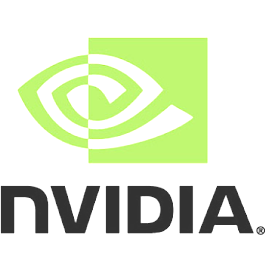

In [9]:
display(out_img)

done